Run on [Kaggle Kernel](https://www.kaggle.com/code/yukismd/image-fasterrcnn)

# Kaggle: [Pytorch Beginner Code : Faster RCNN](https://www.kaggle.com/code/chekoduadarsh/pytorch-beginner-code-faster-rcnn/notebook)

Add data set from https://www.kaggle.com/competitions/vinbigdata-chest-xray-abnormalities-detection

In [1]:
! ls ../input
! ls ../input/vinbigdata-chest-xray-abnormalities-detection -l

vinbigdata-chest-xray-abnormalities-detection
total 4680
-rw-r--r-- 1 nobody nogroup  138026 Dec 30  2020 sample_submission.csv
drwxr-xr-x 2 nobody nogroup       0 Dec 30  2020 test
drwxr-xr-x 2 nobody nogroup       0 Dec 30  2020 train
-rw-r--r-- 1 nobody nogroup 4650790 Dec 30  2020 train.csv


In [2]:
!ls ../input/vinbigdata-chest-xray-abnormalities-detection/train | head -n5

000434271f63a053c4128a0ba6352c7f.dicom
00053190460d56c53cc3e57321387478.dicom
0005e8e3701dfb1dd93d53e2ff537b6e.dicom
0006e0a85696f6bb578e84fafa9a5607.dicom
0007d316f756b3fa0baea2ff514ce945.dicom
ls: write error: Broken pipe


In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random

In [4]:
paddingSize= 0

warnings.filterwarnings("ignore")

DIR_INPUT = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'   # 画像ディレクトリ（学習）
DIR_TEST = f'{DIR_INPUT}/test'     # 画像ディレクトリ（テスト）

## メタデータ（csv）準備

In [5]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [6]:
## csvデータの前処理

train_df.fillna(0, inplace=True)
train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

# FasterRCNN handles class_id==0 as the background.
train_df["class_id"] = train_df["class_id"] + 1
train_df.loc[train_df["class_id"] == 15, ["class_id"]] = 0
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,0,R11,0.0,0.0,1.0,1.0
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,0,R7,0.0,0.0,1.0,1.0
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,1,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,0,R10,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,0,R1,0.0,0.0,1.0,1.0
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,0,R1,0.0,0.0,1.0,1.0
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,0,R8,0.0,0.0,1.0,1.0
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,4,R8,771.0,979.0,1680.0,1311.0


class_name = 'No finding', (x_min, y_min, x_max, y_max) = (0.0, 0.0, 1.0, 1.0)はその画像に検出する物体がないことを意味する

In [7]:
train_df["image_id"].nunique()    # 画像の枚数（学習データ）

15000

In [8]:
c_name = train_df["class_name"].value_counts().index
c_val = train_df["class_name"].value_counts().reset_index(drop=True)
c_id = train_df["class_id"].value_counts().index

c_id_original = c_id-1

df_id = pd.DataFrame({'class_name':c_name, 'class_id':c_id, 'class_id_original':c_id_original, 'count':c_val})
#df_id.loc[df_id['class_id']==0,'class_id_original'] = np.nan
df_id

,class_name,class_id,class_id_original,count
0,No finding,0,-1,31818
1,Aortic enlargement,1,0,7162
2,Cardiomegaly,4,3,5427
3,Pleural thickening,12,11,4842
4,Pulmonary fibrosis,14,13,4655
5,Nodule/Mass,9,8,2580
6,Lung Opacity,8,7,2483
7,Pleural effusion,11,10,2476
8,Other lesion,10,9,2203
9,Infiltration,7,6,1247


Aortic enlargement = 大動脈拡大, Cardiomegaly = 心臓肥大, Pleural thickening = 胸膜肥厚, Pulmonary fibrosis = 肺線維症, Nodule/Mass = 結節・腫瘤, Lung Opacity = 肺混濁, Pleural effusion = 胸水, Other lesion = その他の病変, Infiltration = 浸潤, ILD = ILD, Calcification = 石灰化, Consolidation = 硬化, Atelectasis = 無気肺, Pneumothorax = 気胸

In [9]:
def label_to_name(id):
    """ モデル作成用ID（class_id）を受け取り、クラス名（class_name）を返す
    """
    id = int(id)
    id = id-1
    if id == 0: return "Aortic enlargement"
    if id == 1: return "Atelectasis"
    if id == 2: return "Calcification"
    if id == 3: return "Cardiomegaly"
    if id == 4: return "Consolidation"
    if id == 5: return "ILD"
    if id == 6: return "Infiltration"
    if id == 7: return "Lung Opacity"
    if id == 8: return "Nodule/Mass"
    if id == 9: return "Other lesion"
    if id == 10: return "Pleural effusion"
    if id == 11: return "Pleural thickening"
    if id == 12: return "Pneumothorax"
    if id == 13: return "Pulmonary fibrosis"
    else: return str(id)

In [10]:
label_to_name(0), label_to_name(1), label_to_name(14), 

('-1', 'Aortic enlargement', 'Pulmonary fibrosis')

In [11]:
image_ids = train_df['image_id'].unique()
print(image_ids[:5])
valid_ids = image_ids[-10000:] # 後ろ5000枚 
train_ids = image_ids[:-10000] # 前10000枚
print(image_ids.shape, valid_ids.shape, train_ids.shape)

valid_df = train_df[train_df['image_id'].isin(valid_ids)]   # 検証セット
train_df = train_df[train_df['image_id'].isin(train_ids)]   # 学習セット　        !!! train_dfが上書きされる　!!!
print(valid_df.shape, train_df.shape)

['50a418190bc3fb1ef1633bf9678929b3' '21a10246a5ec7af151081d0cd6d65dc9'
 '9a5094b2563a1ef3ff50dc5c7ff71345' '051132a778e61a86eb147c7c6f564dfe'
 '063319de25ce7edb9b1c6b8881290140']
(15000,) (10000,) (5000,)
(37928, 8) (29986, 8)


In [12]:
## class_idをオリジナルに再修正？

train_df["class_id"] = train_df["class_id"].apply(lambda x: x+1)
valid_df["class_id"] = valid_df["class_id"].apply(lambda x: x+1)

In [13]:
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,1,R11,0.0,0.0,1.0,1.0
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,1,R7,0.0,0.0,1.0,1.0
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,5,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,2,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,1,R10,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
67903,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,12,R9,240.0,1550.0,562.0,2001.0
67906,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,15,R10,1163.0,787.0,1338.0,941.0
67907,22672ab82c290c20b86863291e25ef6c,ILD,7,R9,299.0,664.0,794.0,1508.0
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,5,R8,771.0,979.0,1680.0,1311.0


In [14]:
## class_name='No finding'をドロップ

# BB面積を計算し、1より大きいもののみ
train_df['area'] = (train_df['x_max'] - train_df['x_min']) * (train_df['y_max'] - train_df['y_min'])  # BB面積
valid_df['area'] = (valid_df['x_max'] - valid_df['x_min']) * (valid_df['y_max'] - valid_df['y_min'])
train_df = train_df[train_df['area'] > 1]
valid_df = valid_df[valid_df['area'] > 1]

# class_idが2~14のもののみ
train_df = train_df[(train_df['class_id'] > 1) & (train_df['class_id'] < 15)]
valid_df = valid_df[(valid_df['class_id'] > 1) & (valid_df['class_id'] < 15)]

train_df = train_df.drop(['area'], axis = 1)

print(train_df.shape, valid_df.shape)

(18740, 8) (12701, 9)


In [15]:
train_df['image_id'].nunique(), valid_df['image_id'].nunique()

(2208, 2148)

In [16]:
train_df   # class_idはオリジナルのもの

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,5,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,2,R10,1264.0,743.0,1611.0,1019.0
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,13,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,7,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,10,R9,557.0,2352.0,675.0,2484.0
...,...,...,...,...,...,...,...,...
67891,09b9674023305cb9a0acb367600efffa,Lung Opacity,9,R10,968.0,1020.0,1331.0,1385.0
67899,3b887c0550e9722c9b86b7c22ad09e11,Other lesion,11,R10,254.0,1959.0,280.0,1990.0
67903,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,12,R9,240.0,1550.0,562.0,2001.0
67907,22672ab82c290c20b86863291e25ef6c,ILD,7,R9,299.0,664.0,794.0,1508.0


In [17]:
valid_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,area
6461,ad74c895feae8a322c54bbce08626812,Cardiomegaly,5,R8,933.0,1478.0,1877.0,1837.0,338896.0
6463,f608bb02a0b91160b07fb867bbec84ad,Pleural thickening,13,R10,545.0,285.0,863.0,431.0,46428.0
6468,f5647785cac236ffe0ec3287f9f6aa84,Other lesion,11,R10,859.0,792.0,1083.0,1189.0,88928.0
6485,662fe30af3399b56c1579e95b0c6c87e,Lung Opacity,9,R8,2075.0,1011.0,2873.0,2436.0,1137150.0
6487,0a0ac65c40a9ac441651e4bfbde03c4e,Pleural effusion,12,R10,1145.0,539.0,1781.0,1718.0,749844.0
...,...,...,...,...,...,...,...,...,...
67885,f4da0959856bcdd4b91e0c6949b109e3,Aortic enlargement,2,R9,1567.0,827.0,1830.0,1124.0,78111.0
67888,c75f825862144dbdff940d9c4ecccde8,Aortic enlargement,2,R8,1550.0,608.0,1890.0,1053.0,151300.0
67893,66332eb5425bcdc6854aae970cc656b9,Nodule/Mass,10,R8,2161.0,1600.0,2308.0,1758.0,23226.0
67897,857b9d89572e03adb17d0630b33709ea,Pleural thickening,13,R9,1314.0,494.0,1815.0,825.0,165831.0


## カスタムDataset

In [18]:
# カスタムDataset
class VinBigDataset(Dataset): #Class to load Training Data
    
    def __init__(self, dataframe, image_dir, transforms=None,stat = 'Train'):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()   # 全量の画像ID
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.stat = stat
        
        
    def __getitem__(self, index):
        if self.stat == 'Train':
            
            image_id = self.image_ids[index]    # indexに対応する画像ID(image_id)
            #print('This image ID : {}'.format(image_id))
            records = self.df[(self.df['image_id'] == image_id)]
            records = records.reset_index(drop=True)

            dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")  # DICOM形式データの読み込み

            image = dicom.pixel_array

            if "PhotometricInterpretation" in dicom:
                if dicom.PhotometricInterpretation == "MONOCHROME1":
                    image = np.amax(image) - image

            intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

        
            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if records.loc[0, "class_id"] == 0:
                records = records.loc[[0], :]

            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd

            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']

                target['boxes'] = torch.tensor(sample['bboxes'])

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
                target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)
            
            #return image, target, image_ids
            #return image, target, self.image_ids    # self.image_idsにしておかないと名前空間被るのでは？
            return image, target, image_id     # image_idsでなくimage_idでは？
        
        else:
                   
            image_id = self.image_ids[index]
            records = self.df[(self.df['image_id'] == image_id)]
            records = records.reset_index(drop=True)

            dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            image = dicom.pixel_array

            intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [19]:
train_df["image_id"].unique()[0]

'9a5094b2563a1ef3ff50dc5c7ff71345'

In [20]:
tmp_customds = VinBigDataset(dataframe=train_df, image_dir=DIR_TRAIN, transforms=None, stat='Train')
print(type(tmp_customds))

img_idx = 0   # 確認用画像インデックス
print(len(tmp_customds[img_idx]))   # 3つの返り値
tmp_customds[img_idx]

<class '__main__.VinBigDataset'>
3


(array([[[6.2271066e-02, 6.2271066e-02, 6.2271066e-02],
         [6.2271066e-02, 6.2271066e-02, 6.2271066e-02],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
 
        [[6.2271066e-02, 6.2271066e-02, 6.2271066e-02],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
 
        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],


In [21]:
train_df[train_df['image_id']=='9a5094b2563a1ef3ff50dc5c7ff71345']

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,5,R10,691.0,1375.0,1653.0,1831.0
5517,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,12,R9,1789.0,1729.0,1875.0,1992.0
25023,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,13,R9,1789.0,1729.0,1875.0,1992.0
26165,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,5,R9,692.0,1375.0,1657.0,1799.0
42709,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,5,R8,689.0,1313.0,1666.0,1763.0
53473,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,2,R9,1052.0,715.0,1299.0,966.0


In [22]:
## VinBigDatasetの返り値の1番目

print(type(tmp_customds[img_idx][0]))
tmp_customds[img_idx][0].shape   # 画像のサイズ

<class 'numpy.ndarray'>


(2336, 2080, 3)

In [23]:
tmp_customds[img_idx][0].flatten().min(), tmp_customds[img_idx][0].flatten().max()
# [0,255]のスケール

(0.0, 255.0)

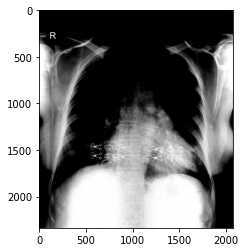

In [24]:
import scipy.stats
plt.imshow(scipy.stats.zscore(tmp_customds[img_idx][0]))   # 正規化（mean=0, sd=1）への変換を実施してプロット

In [25]:
## VinBigDatasetの返り値の2番目

tmp_customds[img_idx][1]   # ラベル情報

{'boxes': array([[ 691., 1375., 1653., 1831.],
        [1789., 1729., 1875., 1992.],
        [1789., 1729., 1875., 1992.],
        [ 692., 1375., 1657., 1799.],
        [ 689., 1313., 1666., 1763.],
        [1052.,  715., 1299.,  966.]]),
 'labels': tensor([ 5, 12, 13,  5,  5,  2]),
 'image_id': tensor([0]),
 'area': tensor([438672.,  22618.,  22618., 409160., 439650.,  61997.]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0])}

In [26]:
## VinBigDatasetの返り値の3番目

tmp_customds[img_idx][2]    # 画像のID（image_id）

'9a5094b2563a1ef3ff50dc5c7ff71345'

## 前処理、データ拡張

In [27]:
def dilation(img): # custom image processing function
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 6, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img

class Dilation(ImageOnlyTransform):
    def apply(self, img, **params):
        return dilation(img)


# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),
        Dilation(),
        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

## Model

[orchvision.models.detection.fasterrcnn_resnet50_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html)

In [28]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [29]:
num_classes = 15   # 14 Classes + 1 background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
print(in_features)    # 学習済みモデルのクラス数

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.roi_heads.box_predictor

1024


FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=15, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=60, bias=True)
)

In [30]:
FastRCNNPredictor(1024, 15)   # クラス数を変更すると、BBの数も自動で変更される（15*4=60）

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=15, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=60, bias=True)
)

In [31]:
#model

## Dataloder

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VinBigDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = VinBigDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()   # 0~len(train_dataset)の間の整数をランダムに並べ替え
print(len(indices))

# Create train and validate data loader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    #batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    #batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

train_data_loader, valid_data_loader

cuda
2208


(<torch.utils.data.dataloader.DataLoader at 0x7fd40aa2afd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd40aa2f5d0>)

In [33]:
dl_test = iter(train_data_loader)
dl_return = next(dl_test)
len(dl_return)  # 3つの返り値

3

In [34]:
# 1つめ
print(len(dl_return[0]))
dl_return[0][0].shape

8


torch.Size([3, 800, 640])

In [35]:
# 2つめ
print(len(dl_return[1]))
dl_return[1][0]

8


{'boxes': tensor([[229.1667, 593.8889, 248.8889, 619.7222],
         [132.7778, 480.8333, 176.3889, 506.6667],
         [518.8889, 413.3333, 547.5000, 450.5556],
         [229.7222, 465.0000, 305.8333, 535.0000],
         [508.3333, 345.8333, 528.8889, 365.5556],
         [ 92.7778, 340.5556, 117.2222, 376.3889],
         [583.6111, 567.7778, 608.6111, 602.2222],
         [348.6111, 634.4444, 446.9444, 652.5000],
         [ 74.4444, 249.4444, 108.0556, 301.1111],
         [508.0556, 344.7222, 546.3889, 376.1111],
         [509.1667, 345.0000, 530.8333, 366.3889],
         [538.8889, 226.3889, 559.1667, 248.0556],
         [538.0556, 226.6667, 562.2222, 250.8333],
         [ 94.1667, 458.0556, 118.0556, 480.2778],
         [160.2778, 621.3889, 223.8889, 644.1667],
         [586.3889, 512.5000, 600.8333, 538.0556],
         [111.1111, 407.2222, 156.9444, 441.3889],
         [333.0556, 517.7778, 370.5556, 560.0000],
         [ 72.5000, 248.8889, 105.5556, 295.8333],
         [ 74.4444, 24

In [36]:
# 3つめ
print(len(dl_return[2]))
dl_return[2][:10]   # 先頭10行

8


('e4b4d6910f4be64483f87b1325ce7fe3',
 'd8bed8c7cbb164f7e8dcc5708ef41f7b',
 'b065d3b4da92b8015b47224341661fd8',
 'd617b24dad98aa3b1f2d645828095355',
 'cad7f3b0b26e674d67eb5a735c0a9bbe',
 '6ab95c0f04cb1c61e635ba82b76df6b9',
 '4d01d09027d1d1e0513de4c8b4fc20e1',
 '2954986a6bc846398d3cc9bc2297ed84')

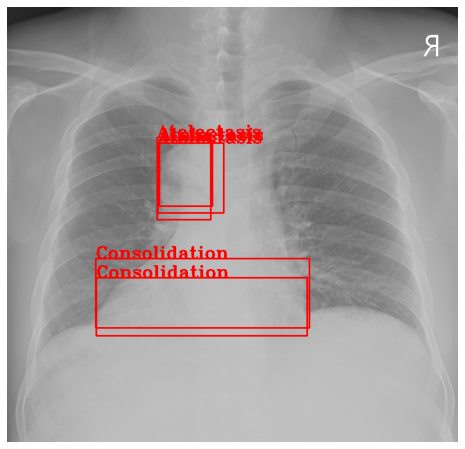

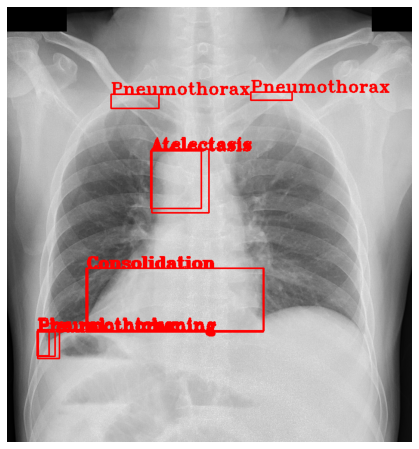

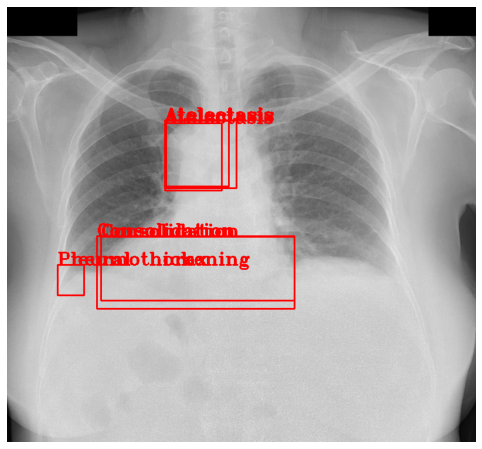

In [37]:
# Train dataset sample
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for number in random.sample([1,2,3],3):
  boxes = targets[number]['boxes'].cpu().numpy().astype(np.int32)
  img = images[number].permute(1,2,0).cpu().numpy()
  labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))

  for i in range(len(boxes)):
      img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
      #print(le.inverse_transform([labels[i]-1])[0])
      #print(label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])))
      img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,1, (255,0,0), 2, cv2.LINE_AA)

  ax.set_axis_off()
  ax.imshow(img)

## モデル学習

In [38]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [39]:
print(device)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs = 1  # Low epoch to save GPU time

cuda


In [40]:
loss_hist = Averager()
itr = 1
lossHistoryiter = []
lossHistoryepoch = []

import time
start = time.time()

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)
        lossHistoryiter.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    lossHistoryepoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Iteration #50 loss: 0.9385925427016827
Iteration #100 loss: 1.0846142834705024
Iteration #150 loss: 0.9935802698895947
Iteration #200 loss: 0.9098950810529052
Iteration #250 loss: 0.7342538781649716
Epoch #0 loss: 0.9198694992763413
Time taken to Train the model :00:20:59.65


In [41]:
len(lossHistoryiter), len(lossHistoryiter)*8  # バッチ数=8

(276, 2208)

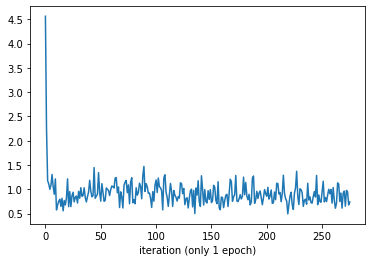

In [42]:
plt.plot(lossHistoryiter)
plt.xlabel('iteration (only 1 epoch)')
plt.show()

## スコアリング

In [43]:
DIR_TEST = f'{DIR_INPUT}/test'
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,14 1 0 0 1 1
2996,ff9fcc4087ed5e941209aa3fa948e364,14 1 0 0 1 1
2997,ffaa288c8abca300974f043b57d81521,14 1 0 0 1 1
2998,ffc441e0c8b7153844047483a577e7c3,14 1 0 0 1 1


In [44]:
labels =  targets[1]['labels'].cpu().numpy()
model.eval()
cpu_device = torch.device("cpu")

In [45]:
test_dataset = VinBigDataset(test_df, DIR_TEST, get_test_transform(),"Test")

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

In [46]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

In [47]:
# Test dataset sample
images, image_ids = next(iter(test_data_loader))
images = list(image.to(device) for image in images)

In [48]:
image_ids

('002a34c58c5b758217ed1f584ccbcfe9',
 '004f33259ee4aef671c2b95d54e4be68',
 '008bdde2af2462e86fd373a445d0f4cd',
 '009bc039326338823ca3aa84381f17f1',
 '00a2145de1886cb9eb88869c85d74080',
 '00b7e6bfa4dc1fe9ddd0ce74743e38c2',
 '011295e0bcdc7636569ab73bfdcc4450',
 '013c169f9dad6f1f6485da961b9f7bf2')

In [49]:
print(len(images))

images[0].size()

8


torch.Size([3, 2584, 2345])

In [50]:
outputs = model(images)
len(outputs)

8

In [51]:
outputs[0]

{'boxes': tensor([[ 824.9032, 1193.4213, 1130.9979, 1544.4128],
         [1135.6367,  659.7665, 1421.5457, 1024.0096],
         [1290.3600,  266.4987, 1682.1411,  373.5791],
         [1315.1072,  229.8965, 1799.8595,  422.6558],
         [1556.5834,  298.8936, 1809.2410,  490.0540],
         [ 633.0227,  271.0594,  976.1291,  381.2639],
         [1392.2468,  262.1311, 1896.5110,  480.3974],
         [ 773.6143, 1202.0470, 1787.2797, 1470.5602],
         [ 683.1121,  234.6584,  921.9180,  416.5569],
         [1381.7517,  243.0893, 1727.6417,  346.7809],
         [1343.5042,  301.4359, 1658.3439,  352.4598],
         [1629.0773,  327.5841, 1785.7990,  438.6725],
         [1416.9841,  290.1236, 1769.5266,  397.9449],
         [1601.7635,  329.9569, 1866.2588,  460.1956],
         [1456.7716,  335.9900, 1791.3000,  459.6153],
         [ 434.2823,  230.7928,  921.2554,  445.0851],
         [1409.8334,  244.9185, 1665.5575,  424.3379],
         [ 557.5127,  287.3538,  912.1469,  405.5650],
 